<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/stn_descriptor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
!git pull origin master

# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


/content
fatal: destination path 'deepLearning' already exists and is not an empty directory.
/content/deepLearning
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
   c5f0470..b7965e6  master     -> origin/master
Updating c5f0470..b7965e6
Fast-forward
 read_data.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
('RAM Free: 12.8 GB', ' | Proc size: 153.9 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
from common import *
!./setup.sh

Using TensorFlow backend.


In [0]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, STNHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
from layers import BilinearInterpolation

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights
  
def get_stn_model(shape):
    init_weights = keras.initializers.he_normal()
    inputs = Input(shape)
    locnet = MaxPooling2D(pool_size=(2, 2))(inputs)
    locnet = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('sigmoid')(locnet)
    weights = get_initial_weights(100)
    locnet = Dense(6, weights=weights)(locnet)
    stn    = BilinearInterpolation(shape[:-1])([inputs, locnet])
    return Model(inputs=inputs, outputs=stn)

In [4]:
%cd /content/deepLearning
!git pull origin master

/content/deepLearning
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
Already up to date.


In [5]:
from get_data import get_data
from read_data import STNHPatches

seqs_train, seqs_test = get_data()

denoise_generator     = STNHPatches(seqs_train, batch_size=500)
denoise_generator_val = STNHPatches(seqs_test, batch_size=500)

100%|██████████| 40/40 [00:15<00:00,  2.01it/s]


In [26]:
# get model
shape = (32, 32, 1)
stn_model = get_stn_model(shape)

# optimiser
opt  = opt = keras.optimizers.nadam()

# loss
loss = 'mean_squared_error'

# train network
def ssim_loss(a,p):
  return 1 - tf.image.ssim(a, p, max_val=1.0)

# callbacks
callbacks = [
    #keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

stn_model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
stn_history = stn_model.fit_generator(generator=denoise_generator, epochs=50, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Epoch 1/50
1169/1169 [==============================] - 76s 65ms/step - loss: 2026.9877 - acc: 0.0586 - val_loss: 2216.6406 - val_acc: 0.0596

Epoch 00001: val_loss improved from inf to 2216.64057, saving model to data/denoise_model.weights.01-2216.64.hdf5
Epoch 2/50
1169/1169 [==============================] - 75s 64ms/step - loss: 2008.1603 - acc: 0.0615 - val_loss: 1857.4938 - val_acc: 0.0667

Epoch 00002: val_loss improved from 2216.64057 to 1857.49379, saving model to data/denoise_model.weights.02-1857.49.hdf5
Epoch 3/50
1169/1169 [==============================] - 75s 64ms/step - loss: 1989.5813 - acc: 0.0641 - val_loss: 1341.7738 - val_acc: 0.0767

Epoch 00003: val_loss improved from 1857.49379 to 1341.77384, saving model to data/denoise_model.weights.03-1341.77.hdf5
Epoch 4/50
1169/1169 [==============================] - 75s 64ms/step - loss: 2006.4245 - acc: 0.0656 - val_loss: 1812.7652 - val_acc: 0.0592

Epoch 00004: val_loss did not improve from 1341.77384
Epoch 5/50
1169/11

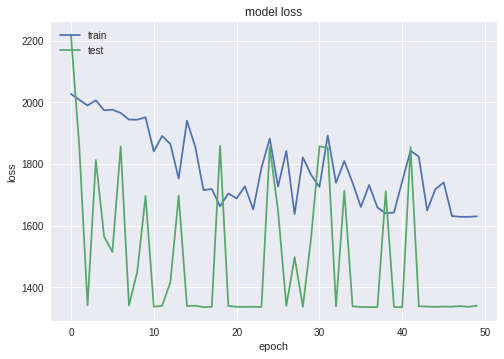

In [27]:

plt.plot(stn_history.history['loss'])
plt.plot(stn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()